In [47]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable
from torchmetrics.aggregation import MeanMetric
from torchmetrics import Metric, MetricTracker as _MetricTracker, MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall

EPOCH_PREFIX = "epoch"


class LossMetric(MeanMetric):
    def __init__(self, loss: torch.nn.Module):
        super().__init__()
        self.loss_fn = loss

    def update(self, pred, target):
        loss = self.loss_fn(pred, target)
        super().update(loss)


class MissingStepKeyException(Exception):
    pass


class Metrics(MetricCollection):

    def __init__(self):
        metrics = {"acc": BinaryAccuracy(), "pre": BinaryPrecision(), "rec": BinaryRecall()}
        metrics = self._format_metrics(metrics)
        loss = metrics.get("loss", torch.nn.MSELoss())

        super().__init__(metrics)
        self.loss = LossMetric(loss)

    def _format_metrics(self, metrics: dict[Metric] | None) -> dict[str, Metric]:
        if metrics is None:
            return {}
        if isinstance(metrics, dict):
            return metrics
        raise ValueError(
            "The return type of the model.configure_metrics function should be a dict[torchmetrics.Metric], or None"
        )

    def update(self, pred, target):
        self.loss.update(pred, target)
        super().update(pred, target)
        # return {**metric_val, "loss": loss_val}

    def compute(self):
        loss_val = self.loss.compute()
        metric_vals = super().compute()
        return {**metric_vals, "loss": loss_val}


class MetricTracker(_MetricTracker):

    NO_NA_COLUMNS = ["stage", "epoch", "step"]

    def __init__(self, status):
        self.status = status
        self.records = pd.DataFrame([], columns=["stage", "epoch", "step"])

        self.current_step_metrics: dict[str, float] = {}
        self.current_epoch_metrics: dict[str, float] = {}

        super().__init__(Metrics())

    def _detach(self, x):
        if isinstance(x, torch.Tensor):
            if len(x.shape) == 0:
                return x.item()
            else:
                return x.detach().cpu().numpy()
        return x

    def _extract_output(self, output: dict[str, torch.Tensor]) -> tuple[torch.Tensor, torch.Tensor]:
        out_metric, out_target = output['metric'], output['target']
        return out_metric, out_target

    def _register_metrics(
        self,
        metrics: dict[str, torch.Tensor],
    ) -> dict[str, float]:
        for col in metrics.keys():
            if col not in self.records.columns:
                self.records[col] = np.nan
        metrics = {k: self._detach(v) for k, v in metrics.items()}
        for k, v in self.status.to_dict().items():
            metrics[k] = v
        self.records.loc[len(self.records)] = metrics

    def _register_step_metrics(self, output) -> dict[str, float]:
        out_metric, out_target = self._extract_output(output)
        step_metrics = super().forward(out_metric, out_target)
        self._register_metrics(step_metrics)
        return step_metrics

    # =================== epoch_start ===================

    def on_epoch_start(self):
        self.increment()

    # =================== epoch_end ===================

    def _on_epoch_end(self, ):
        def prefix_cb(name: str):
            return f"{EPOCH_PREFIX}_{name}"

        epoch_metrics = self.compute()
        epoch_metrics = {prefix_cb(k): v for k, v in epoch_metrics.items()}
        self.current_epoch_metrics = self._register_metrics(epoch_metrics)

    def _records_filter_cols(self, with_epoch=True) -> pd.DataFrame:
        cols = [
            c
            for c in self.records.columns
            if (with_epoch and c.startswith(EPOCH_PREFIX))
            or (not with_epoch and not c.startswith(EPOCH_PREFIX))
        ]
        return self.records[cols].dropna()

    def get_step_records(self) -> pd.DataFrame:
        return self._records_filter_cols(with_epoch=False)

    def get_epoch_records(self) -> pd.DataFrame:
        return self._records_filter_cols(with_epoch=True)

    def get_last_step_metrics(self):
        return self.current_step_metrics

    def get_last_epoch_metrics(self):
        return self.current_epoch_metrics

    def step(self, output) -> dict[str, float]:
        self.current_step_metrics = self._register_step_metrics(output)

    def plot(self, axs=None):
        ncols = len(self.metrics)
        _, axs = (
            (_, axs)
            if axs is not None
            else plt.subplots(nrows=1, ncols=ncols, figsize=(ncols * 5, 5))
        )
        for metric, ax in zip(self.metrics.values(), axs.flatten()):
            metric.plot(ax=ax)
        plt.tight_layout()
        plt.show()

In [48]:
a = torch.tensor([1, 2, 3, 4, 10]).float()
torch.softmax(a, dim=0), torch.softmax(a / 0.5, dim=0), torch.softmax(
    a / 2, dim=0
), torch.softmax(a / 8, dim=0)

(tensor([1.2294e-04, 3.3418e-04, 9.0839e-04, 2.4692e-03, 9.9617e-01]),
 tensor([1.5230e-08, 1.1253e-07, 8.3152e-07, 6.1442e-06, 9.9999e-01]),
 tensor([0.0100, 0.0165, 0.0272, 0.0449, 0.9014]),
 tensor([0.1257, 0.1425, 0.1615, 0.1830, 0.3873]))

In [64]:
from torch.utils.data import Dataset, DataLoader


class Data(Dataset):
    def __init__(self):
        self.items = torch.rand(128, 4)
        self.targets = (self.items[:, 0] > 0.3).float().unsqueeze(1)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        return self.items[idx], self.targets[idx]


tr_data = Data()
ev_data = Data()


class Status:
    epoch = 0
    step = 0

    def to_dict(self):
        return self.__dict__


class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(4, 16),
            torch.nn.Linear(16, 16),
            torch.nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.nn(x)


model = Model()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

status = Status()
tracker = MetricTracker(status)

In [65]:
for e in range(64):
    loader = DataLoader(tr_data, batch_size=32, shuffle=True)
    status.epoch += 1
    tracker.on_epoch_start()
    for batch, target in loader:
        out = model(batch)
        output = {
            "pred": out,
            "metric": torch.sigmoid(out),
            "target": target
        }
        tracker.step(output)

        optim.zero_grad()
        loss = loss_fn(out, target)
        loss.backward()
        optim.step()

        status.step += 1
    tracker._on_epoch_end()


tracker.records

,stage,epoch,step,acc,pre,rec,loss,epoch_acc,epoch_pre,epoch_rec,epoch_loss
0,NaN,1,NaN,0.65625,0.656250,1.0,0.245933,NaN,NaN,NaN,NaN
1,NaN,1,1.0,0.62500,0.625000,1.0,0.235200,NaN,NaN,NaN,NaN
2,NaN,1,2.0,0.62500,0.625000,1.0,0.247479,NaN,NaN,NaN,NaN
3,NaN,1,3.0,0.68750,0.687500,1.0,0.236038,NaN,NaN,NaN,NaN
4,NaN,1,4.0,NaN,NaN,NaN,NaN,0.648438,0.648438,1.0,0.241163
...,...,...,...,...,...,...,...,...,...,...,...
315,NaN,64,252.0,0.62500,0.600000,1.0,0.179385,NaN,NaN,NaN,NaN
316,NaN,64,253.0,0.71875,0.709677,1.0,0.155667,NaN,NaN,NaN,NaN
317,NaN,64,254.0,0.68750,0.687500,1.0,0.158447,NaN,NaN,NaN,NaN
318,NaN,64,255.0,0.71875,0.700000,1.0,0.155856,NaN,NaN,NaN,NaN


<Axes: xlabel='step'>

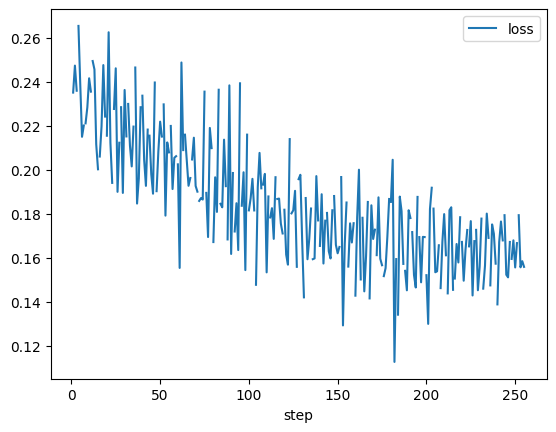

In [66]:
tracker.records.plot(x='step', y='loss')

In [ ]:
loader = DataLoader(ev_data, batch_size=16)
batch, target = next(iter(loader))
out = model(batch)
torch.cat((out.unsqueeze(0), target.unsqueeze(0))).T

/tmp/ipykernel_26150/1243746614.py:4: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  torch.cat((out.unsqueeze(0), target.unsqueeze(0))).T


tensor([[[ 0.5666,  1.0000],
         [ 0.5292,  1.0000],
         [-0.1370,  0.0000],
         [ 0.0777,  0.0000],
         [ 0.4440,  1.0000],
         [ 1.0140,  1.0000],
         [ 0.3979,  0.0000],
         [ 1.3361,  1.0000],
         [ 0.2826,  0.0000],
         [ 1.1905,  1.0000],
         [ 0.5683,  1.0000],
         [ 0.0251,  0.0000],
         [ 0.3605,  0.0000],
         [ 0.6799,  1.0000],
         [ 0.0144,  0.0000],
         [ 0.8884,  1.0000]]], grad_fn=<PermuteBackward0>)

In [ ]:
import pyroml as p
from pyroml.template.iris import IrisNet, IrisDataset, load_dataset


class ScheduledIrisNet(IrisNet):
    def configure_optimizers(self, loop: "p.Loop"):
        tr = self.trainer
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=tr.lr)
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=tr.lr,
            total_steps=loop.total_steps,
            steps_per_epoch=loop.steps_per_epochs,
            epochs=tr.max_epochs,
            anneal_strategy="cos",
            cycle_momentum=False,
            div_factor=1e2,
            final_div_factor=0.05,
        )

    def forward(self, x):
        return super().forward(x)

ScheduledIrisNet(
  (module): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=3, bias=True)
    (5): Softmax(dim=1)
  )
)

In [81]:
ds = load_dataset()
ds = ds.shuffle(seed=42)
tr_ds, ev_ds, te_ds = np.split(ds, [int(0.6 * len(ds)), int(0.7 * len(ds))])

tr_ds = IrisDataset(tr_ds)
ev_ds = IrisDataset(ev_ds)
te_ds = IrisDataset(te_ds)

len(tr_ds), len(ev_ds), len(te_ds)

(90, 15, 45)

In [94]:
model = ScheduledIrisNet(mid_dim=64)

optim = torch.optim.AdamW(model.parameters(), lr=0.02)
loss_fn = torch.nn.MSELoss()

status = Status()
tracker = MetricTracker(status)

for e in range(256):
    loader = DataLoader(tr_ds, batch_size=30, shuffle=True)
    status.epoch += 1
    tracker.on_epoch_start()
    l = 0
    for batch, target in loader:
        out = model(batch)
        output = {"pred": out, "metric": out, "target": target}
        tracker.step(output)

        optim.zero_grad()
        loss = loss_fn(out, target)
        loss.backward()
        optim.step()
        l += loss.item()

        status.step += 1
    
    tracker._on_epoch_end()


tracker.records

,stage,epoch,step,acc,pre,rec,loss,epoch_acc,epoch_pre,epoch_rec,epoch_loss
0,NaN,1,NaN,0.666667,0.000000,0.000000,0.223825,NaN,NaN,NaN,NaN
1,NaN,1,1.0,0.577778,0.366667,0.366667,0.336002,NaN,NaN,NaN,NaN
2,NaN,1,2.0,0.588889,0.370370,0.333333,0.234820,NaN,NaN,NaN,NaN
3,NaN,1,3.0,NaN,NaN,NaN,NaN,0.611111,0.368421,0.233333,0.264883
4,NaN,2,3.0,0.777778,1.000000,0.333333,0.203104,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1019,NaN,255,765.0,NaN,NaN,NaN,NaN,0.977778,0.966667,0.966667,0.012934
1020,NaN,256,765.0,0.977778,0.966667,0.966667,0.007640,NaN,NaN,NaN,NaN
1021,NaN,256,766.0,1.000000,1.000000,1.000000,0.001193,NaN,NaN,NaN,NaN
1022,NaN,256,767.0,0.977778,0.966667,0.966667,0.013570,NaN,NaN,NaN,NaN


<Axes: xlabel='epoch'>

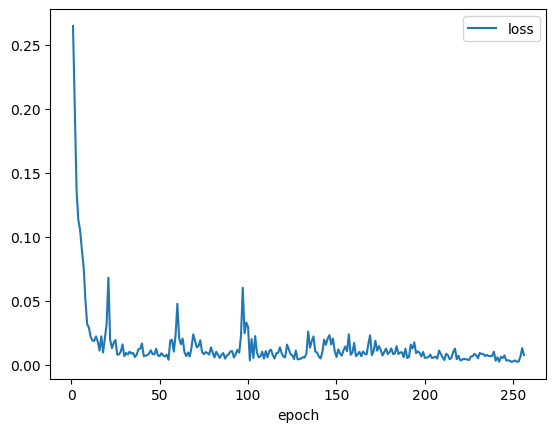

In [95]:
tracker.records.groupby("epoch").mean().plot(y="loss")

<Axes: xlabel='epoch'>

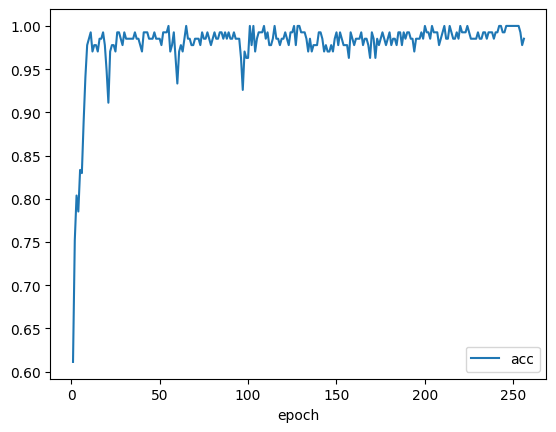

In [96]:
tracker.records.groupby("epoch").mean().plot(y="acc")

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='BinaryAccuracy'>)

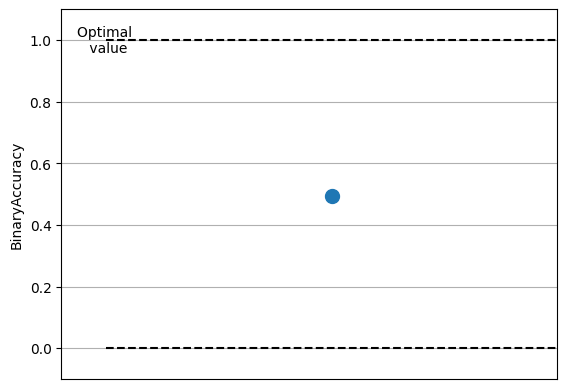

In [113]:
tracker[-1].collection.acc.plot()

<Axes: >

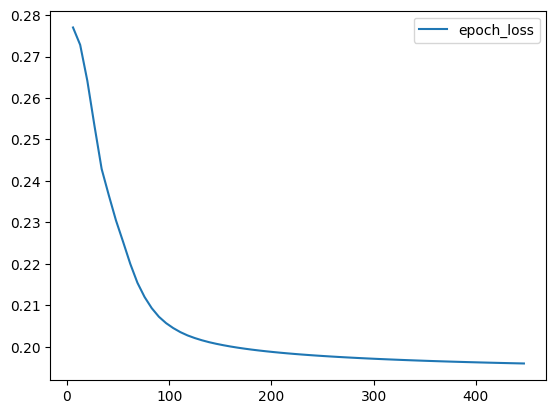

In [106]:
tracker.get_epoch_records()[["epoch_loss"]].plot()

In [128]:
from torch import randint
from torchmetrics.wrappers import MetricTracker
from torchmetrics.classification import MulticlassAccuracy


p.seed_everything(42)
tracker = MetricTracker(MulticlassAccuracy(num_classes=10, average="micro"))
for epoch in range(5):
    tracker.increment()
    for batch_idx in range(5):
        res = tracker.update(randint(10, (100,)), randint(10, (100,)))
        print(res)
    print(f"current acc={tracker.compute()}")

None
None
None
None
None
current acc=0.1120000034570694
None
None
None
None
None
current acc=0.08799999952316284
None
None
None
None
None
current acc=0.12600000202655792
None
None
None
None
None
current acc=0.07999999821186066
None
None
None
None
None
current acc=0.10199999809265137


In [10]:
from torch import randint
from torchmetrics.classification import MulticlassAccuracy


tracker = _MetricTracker(MulticlassAccuracy(num_classes=10, average="micro"))
for epoch in range(5):
    tracker.increment()
    for batch_idx in range(5):
        tracker(randint(10, (100,)), randint(10, (100,)))
    print(f"current acc={tracker.compute()}")

current acc=0.09200000017881393
current acc=0.10599999874830246
current acc=0.1120000034570694
current acc=0.09200000017881393
current acc=0.09600000083446503


In [11]:
tracker[-1]

MulticlassAccuracy()